# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [247]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Clean Britney playlist data

In [300]:
britney_df = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [301]:
britney_df =britney_df.drop_duplicates(subset='track_id')
britney_df.shape

(1193, 21)

In [302]:
britney_df = britney_df.dropna()
britney_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1189,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1190,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1191,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


### 2. Read training data 

In [304]:
genre_names = ["Jazz", "Pop", "Reggae", "Classical", "Country"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

Jazz
Pop
Reggae
Classical
Country


In [305]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((479, 7), (8856, 22))

In [306]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [307]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8852, 22)

In [308]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8746, 22)

<AxesSubplot:>

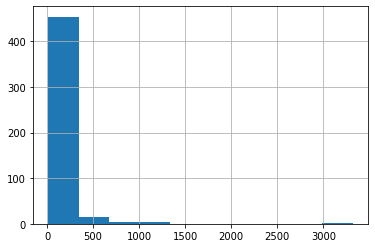

In [208]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

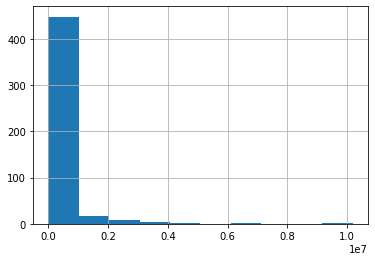

In [309]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [310]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

classical    0.272925
jazz         0.199634
pop          0.188772
reggae       0.186028
country      0.152641
Name: genre, dtype: float64

### 2. Refine the training data

In [311]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWVqfgj8NZEp1,Coffee Table Jazz,140,spotify,Spotify,2282279,jazz
1,37i9dQZF1DXbITWG1ZJKYt,Jazz Classics,100,spotify,Spotify,1905763,jazz
2,37i9dQZF1DX4wta20PHgwo,Late Night Jazz,80,spotify,Spotify,1852668,jazz
3,37i9dQZF1DX0SM0LYsmbMT,Jazz Vibes,350,spotify,Spotify,1775132,jazz
4,37i9dQZF1DWTbzY5gOVvKd,Jazzy Romance,60,spotify,Spotify,996283,jazz


In [312]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [213]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [214]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    2407.000000
mean        0.762869
std         0.174076
min         0.000000
25%         0.663653
50%         0.826147
75%         0.894885
max         1.000000
Name: loudness, dtype: float64

In [215]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()

count    2407.000000
mean        0.527422
std         0.154373
min         0.000000
25%         0.409178
50%         0.486401
75%         0.623485
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [216]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [217]:
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

In [218]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,2wOlZrHUpRP9hQbqbV9Ae5,Together,0Cioop2zjxXxtcPUme7R46,Matthew Halsall,1fcREbFQfCqfwxXkxGgvV7,672520,2009-10-26,61,0.401,0.0236,...,0.978,0.57900,0.1020,0.163,0.516468,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,11.208667,2
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,41sYqKPEygmvQrLXKpzWJU,167121,2020-04-17,62,0.327,0.1450,...,0.945,0.88400,0.0910,0.136,0.836329,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,2.785350,2
2,2R1vQwYTC0sl93C6oyVuHC,Simplicity,0FAC6FNPb4LsY5uyp0xTWF,Edward Simon,4GDYdHheKfIOBMjqOgTK6k,309586,2020-10-09,58,0.493,0.1070,...,0.881,0.90600,0.1220,0.126,0.426777,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,5.159767,2
3,7zzaZggdFuadOs0R7SuJlp,My Ideal,5CSkWcdoRvgBQDwJTZZstJ,Jerry Bergonzi,2T8WUL1jRlaGIqj36oD5O5,219766,2021-01-15,45,0.526,0.0767,...,0.802,0.00195,0.0978,0.247,0.526978,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,3.662767,2
4,7LIFp3v3CaTCvcG6fmceIg,Clouds,7c7414LKkYnuDPlkrwDg9a,Portraits in Jazz,3LEyIlY9P6z9Mvp6dpxk9d,283650,2020-11-27,56,0.338,0.1650,...,0.977,0.31500,0.1220,0.174,0.356400,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,4.727500,2


In [219]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'jazz', 3: 'pop', 4: 'reggae', 0: 'classical', 1: 'country'}

## 4. Train a KNN model

In [40]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


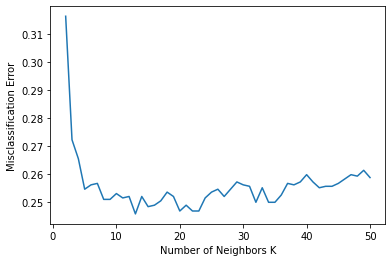

The optimal number of neighbors is 13 with score 75%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


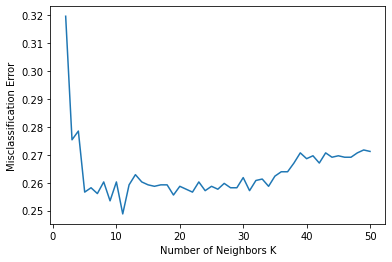

The optimal number of neighbors is 11 with score 75%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


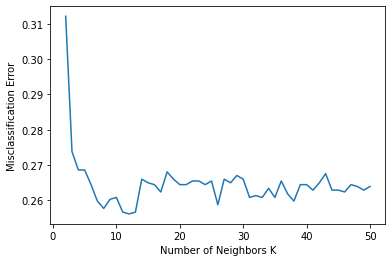

The optimal number of neighbors is 12 with score 74%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


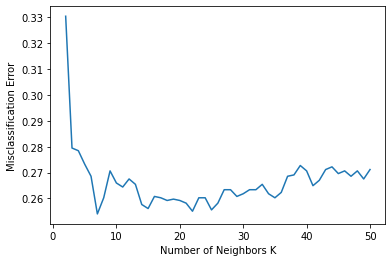

The optimal number of neighbors is 7 with score 74%


In [220]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [221]:
results_optimal_k

[13, 11, 12, 7]

### 5. Model Prediction

In [222]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [223]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [224]:
chart_tracks_df = chart_tracks_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 7


In [225]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
3269,4Dq2FjRkOTHcssggMdYK8J,MY TREASURE,3KonOYiLsU53m4yT7gNotP,TREASURE,5tQDFmW8QrZdTsICpLQBTL,195982,2021-01-11,64,0.730,0.785,...,0.526,0.340633,4,reggae,1.0,0.0,0.142857,0.428571,0.428571,0.000000
2333,2tnVG71enUj33Ic2nFN6kZ,Ride It,4ofCBoyEiGSePFAG500xev,Regard,4zOhjJfe0dwqsNdDYk622E,157605,2019-07-26,86,0.880,0.751,...,0.884,0.402269,4,reggae,1.0,0.0,0.000000,0.571429,0.428571,0.000000
1563,0sdbFOyfgAhAhWq8DpzkaW,the light is coming (feat. Nicki Minaj),66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,3tx8gQqWbGwqIGZHqDNrGe,228373,2018-08-17,63,0.877,0.547,...,0.687,0.285888,4,reggae,1.0,0.0,0.000000,0.142857,0.857143,0.000000
2143,14BG5B1EJSCyNpZt096xXc,"Patawad, Paalam",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,4Lavp71TTVIdkw8yNY8LhA,323140,2019-06-14,54,0.472,0.288,...,0.193,0.156383,2,jazz,1.0,0.0,0.000000,0.000000,0.285714,0.714286
2753,47EWMOElkkbMp5m9SBkx7d,IDK You Yet,6sFHvCyqklnJpXC9Nh1aag,Alexander 23,2BcmdSV1kyss7KFuSpobeS,184638,2020-04-09,51,0.629,0.306,...,0.191,0.150273,2,jazz,1.0,0.0,0.571429,0.142857,0.285714,0.000000


Check out tracks with highest assigned probability

In [226]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
3269,TREASURE,MY TREASURE,reggae,1.000000
2333,Regard,Ride It,reggae,1.000000
1563,Ariana Grande,the light is coming (feat. Nicki Minaj),reggae,1.000000
2143,Moira Dela Torre,"Patawad, Paalam",jazz,1.000000
2753,Alexander 23,IDK You Yet,jazz,1.000000
2000,Russ,Nobody Knows,reggae,1.000000
3202,Taylor Swift,happiness,jazz,1.000000
1570,Calvin Harris,Promises (with Sam Smith),reggae,1.000000
1999,Rex Orange County,Happiness,jazz,1.000000
762,Sam Smith,Lay Me Down,jazz,1.000000


View histogram of predicted genre probabilities

<AxesSubplot:>

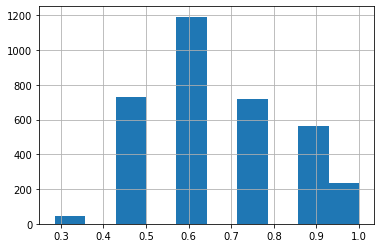

In [227]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [228]:
chart_tracks_df['predicted_genre'].value_counts()

pop          1240
reggae        977
country       699
jazz          543
classical      30
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [229]:
this_song = 'Lay Me Down'
chart_tracks_df[chart_tracks_df['track_name'].str.contains('Lay Me Down')]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
762,64GRDrL1efgXclrhVCeuA0,Lay Me Down,2wY79sveU1sp5g7SokKOiI,Sam Smith,0vrWqbRQEMKqhTGcDLQK7x,219535,2015-11-06,75,0.468,0.19,...,0.326,0.447624,2,jazz,1.0,0.0,0.0,0.0,0.285714,0.714286


In [230]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [294]:
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob,cosine_dist,euclidean_dist,manhattan_dist
3269,4Dq2FjRkOTHcssggMdYK8J,MY TREASURE,3KonOYiLsU53m4yT7gNotP,TREASURE,5tQDFmW8QrZdTsICpLQBTL,195982,2021-01-11,64,0.730,0.785,...,reggae,1.0,0.0,0.142857,0.428571,0.428571,0.000000,0.778530,0.044,0.044
2333,2tnVG71enUj33Ic2nFN6kZ,Ride It,4ofCBoyEiGSePFAG500xev,Regard,4zOhjJfe0dwqsNdDYk622E,157605,2019-07-26,86,0.880,0.751,...,reggae,1.0,0.0,0.000000,0.571429,0.428571,0.000000,0.772100,0.106,0.106
1563,0sdbFOyfgAhAhWq8DpzkaW,the light is coming (feat. Nicki Minaj),66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,3tx8gQqWbGwqIGZHqDNrGe,228373,2018-08-17,63,0.877,0.547,...,reggae,1.0,0.0,0.000000,0.142857,0.857143,0.000000,0.814199,0.103,0.103
2143,14BG5B1EJSCyNpZt096xXc,"Patawad, Paalam",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,4Lavp71TTVIdkw8yNY8LhA,323140,2019-06-14,54,0.472,0.288,...,jazz,1.0,0.0,0.000000,0.000000,0.285714,0.714286,0.884697,0.302,0.302
2753,47EWMOElkkbMp5m9SBkx7d,IDK You Yet,6sFHvCyqklnJpXC9Nh1aag,Alexander 23,2BcmdSV1kyss7KFuSpobeS,184638,2020-04-09,51,0.629,0.306,...,jazz,1.0,0.0,0.571429,0.142857,0.285714,0.000000,0.887468,0.145,0.145


In [295]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_country_prob',
       'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_reggae_prob',
       'cosine_dist', 'euclidean_dist', 'manhattan_dist'],
      dtype='object')

In [296]:
#read data
britney_df=pd.read_csv("data/Britney_Spears_playlist_tracks_data.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.713767,0,0.0307,0.2020,0.000131,0.4430,0.907,0.218504,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.807438,0,0.1140,0.0249,0.025000,0.2420,0.924,0.550393,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.729166,0,0.0437,0.3000,0.000018,0.3550,0.894,0.232375,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,0.740318,1,0.0622,0.0730,0.000000,0.0889,0.235,0.523619,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,0.847496,1,0.0334,0.2500,0.000678,0.0723,0.382,0.353460,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [262]:
# Input seed track here
seed_track_name = 'Oops!...I Did It Again'

In [263]:
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

In [264]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[feature_cols]

In [265]:
seed_track_data = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
seed_track_data = seed_track_data[feature_cols].iloc[1]
seed_track_data

danceability          0.7740
energy                0.8380
loudness             -3.9140
speechiness           0.1140
acousticness          0.0249
instrumentalness      0.0250
liveness              0.2420
valence               0.9240
tempo               143.0400
Name: 1, dtype: float64

In [266]:
seed_track_data['track_id'] = '6naxalmIoLFWR0siv8dnQQ'
seed_track_data

danceability                         0.774
energy                               0.838
loudness                            -3.914
speechiness                          0.114
acousticness                        0.0249
instrumentalness                     0.025
liveness                             0.242
valence                              0.924
tempo                               143.04
track_id            6naxalmIoLFWR0siv8dnQQ
Name: 1, dtype: object

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [276]:
chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

<ipython-input-276-6cabc79014b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\


,track_name,artist_name,euclidean_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1823,Wonderful Christmastime [Edited Version] - Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
450,Attention,Charlie Puth,0.000,reggae,0.774,0.626,0.811382,0.0432,0.0969,0.000031,0.0848,0.777,0.292085
2571,Blueberry Faygo,Lil Mosey,0.000,pop,0.774,0.554,0.669028,0.0383,0.2070,0.000000,0.1320,0.349,0.285888
29,Shout Out to My Ex,Little Mix,0.000,reggae,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
94,Cake By The Ocean,DNCE,0.000,reggae,0.774,0.764,0.769908,0.0518,0.1560,0.000000,0.0383,0.912,0.408724
3239,Cozy Little Christmas,Katy Perry,0.000,reggae,0.774,0.608,0.736377,0.1280,0.1280,0.000000,0.0895,0.560,0.522539
3222,Wonderful Christmastime - Edited Version / Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
1299,Shout Out to My Ex,Little Mix,0.000,reggae,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
2323,Writing on the Wall (feat. Post Malone & Cardi B),French Montana,0.001,reggae,0.773,0.836,0.897605,0.1530,0.2830,0.000021,0.0828,0.497,0.365732
1820,Hope,The Chainsmokers,0.001,reggae,0.773,0.699,0.747922,0.0958,0.4880,0.000004,0.0814,0.513,0.322235


In [277]:
chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

<ipython-input-277-f061d4b7e214>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\


,track_name,artist_name,manhattan_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3239,Cozy Little Christmas,Katy Perry,0.000,reggae,0.774,0.608,0.736377,0.1280,0.1280,0.000000,0.0895,0.560,0.522539
2571,Blueberry Faygo,Lil Mosey,0.000,pop,0.774,0.554,0.669028,0.0383,0.2070,0.000000,0.1320,0.349,0.285888
1823,Wonderful Christmastime [Edited Version] - Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
450,Attention,Charlie Puth,0.000,reggae,0.774,0.626,0.811382,0.0432,0.0969,0.000031,0.0848,0.777,0.292085
94,Cake By The Ocean,DNCE,0.000,reggae,0.774,0.764,0.769908,0.0518,0.1560,0.000000,0.0383,0.912,0.408724
29,Shout Out to My Ex,Little Mix,0.000,reggae,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
3222,Wonderful Christmastime - Edited Version / Rem...,Paul McCartney,0.000,reggae,0.774,0.511,0.627881,0.0319,0.3220,0.000000,0.0672,0.771,0.259442
1299,Shout Out to My Ex,Little Mix,0.000,reggae,0.774,0.739,0.828168,0.0952,0.0316,0.000006,0.1190,0.823,0.451827
1467,all the kids are depressed,Jeremy Zucker,0.001,jazz,0.773,0.437,0.653797,0.0963,0.8360,0.000024,0.5440,0.707,0.315590
299,As Long as You Love Me,Backstreet Boys,0.001,reggae,0.775,0.816,0.766264,0.0281,0.1640,0.000000,0.1260,0.753,0.280874


In [297]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

chart_tracks_df.sort_values(by='cosine_dist',ascending=False).head()

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

<ipython-input-297-46d947133a77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\


,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3244,Snowfall on Christmas Eve,The Rossman Ensemble,0.300439,reggae,0.575,0.411,0.536663,0.0722,0.0251,0.069300,0.0751,0.4620,1.000000
1600,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,0.331884,country,0.264,0.273,0.638649,0.0312,0.5350,0.000000,0.2070,0.3150,0.911930
1781,Demonyo,juan karlos,0.334029,pop,0.415,0.508,0.617441,0.0363,0.0509,0.016200,0.1030,0.1140,0.837889
3412,Untouchable (Taylor’s Version),Taylor Swift,0.349277,pop,0.393,0.531,0.742600,0.0329,0.0181,0.000000,0.1690,0.2240,0.909555
1529,"Closer You and I - From ""Loving in Tandem""",Michael Pangilinan,0.349364,pop,0.207,0.535,0.713613,0.0414,0.2010,0.000000,0.3360,0.2640,0.906589
755,Dusk Till Dawn - Radio Edit,ZAYN,0.356358,pop,0.258,0.437,0.722907,0.0390,0.1010,0.000001,0.1060,0.0967,0.784350
808,Pray,Sam Smith,0.360518,pop,0.381,0.379,0.609621,0.0501,0.2920,0.000003,0.0864,0.1530,0.753732
1011,Bibingka,Ben&Ben,0.367287,pop,0.356,0.229,0.502149,0.0328,0.7970,0.000000,0.1120,0.4310,0.932217
2977,The Bells At Christmas,Jose Mari Chan,0.369371,country,0.227,0.352,0.572242,0.0321,0.3160,0.000001,0.1290,0.6760,0.856871
1085,The Good Side,Troye Sivan,0.375492,jazz,0.424,0.259,0.316929,0.0531,0.4180,0.002470,0.3540,0.3160,0.696434


array([[<AxesSubplot:title={'center':'euclidean_dist'}>,
        <AxesSubplot:title={'center':'manhattan_dist'}>],
       [<AxesSubplot:title={'center':'cosine_dist'}>, <AxesSubplot:>]],
      dtype=object)

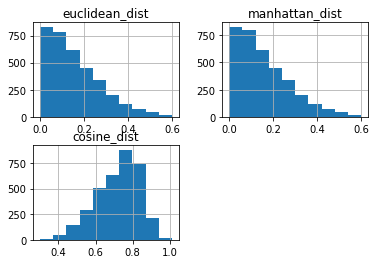

In [279]:
chart_tracks_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

Modify similarity criteria